In [1]:
import torch
from torch import nn as nn
from torch import utils as utils
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch import optim
from torchvision import transforms, datasets
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
CIFAR10_label_to_use=1
num_epochs=50
batch_size=64
train_generator_every_n_batches=2
inner_loop_disc=1     #train discriminator for these number of batches before training generator
inner_loop_gen=5      #train generator for these many batches of generated samples every time

In [4]:
class Generator(nn.Module):
    def __init__(self, C_in=100,C_h=64,C_o=3):
        super().__init__()
        self.C_in,self.C_h,self.C_o = C_in,C_h,C_o
        self.layers=nn.Sequential(
            nn.ConvTranspose2d(C_in,512,4),                      #512 x 4 x 4 output
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512,256,4, stride=2,padding=1),   #256 x 8 x 8 output
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256,128,4, stride=2, padding=1),   #128 x 16 x 16 output
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128,C_o,4, stride=2, padding=1),   #C_o x 32 x 32 output
            nn.BatchNorm2d(C_o),
            nn.Tanh()                           #Why Tanh? shouldn't pixels be of values 0-1
        )
    def forward(self, X): return self.layers(X)
    def name(self):       return "Generator"

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(
            #Assuming Input as 3 x 32 x 32 which is for cifar10
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(inplace=True),             #output shape= batch_size x 128 x 16 x 16
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(inplace=True),             #output shape= batch_size x 256 x 8 x 8
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(inplace=True),             #output shape= batch_size x 512 x 4 x 4
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()                       #output shape= batch_size x 1 x 1 x 1
        )
    def forward(self, X): return torch.reshape(self.layers(X), (-1,))  #reshape output to batchsize only
    def name(self):       return "Discriminator"

In [6]:
class Discriminator_LogProb_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x_d, x_g,dd,gg):
        totloss = -torch.log(dd(x_d)) - torch.log(1-dd(gg(x_g).detach()))
        return totloss.mean()

class Generator_LogProb_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x_g,dd,gg):
#         totloss = torch.log(1-dd(gg(x_g)))
        totloss = -torch.log(dd(gg(x_g)))
        return totloss.mean()

In [7]:
class Cifar1(utils.data.Dataset):
    def __init__(self, label):
        self.label=label
        self.dataset=datasets.CIFAR10('./data', train=True, download=True,
                           transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(*self.get_mean_std(label))
#                            transforms.Normalize((0.5,),(0.5,))
                       ]))
        self.indices=[i for i,(x,y) in enumerate(self.dataset) if y==label]
    def __getitem__(self, i):
        return self.dataset[self.indices[i]]
    def __len__(self): return len(self.indices)
    
    @staticmethod
    def get_mean_std(label_in_cifar10):
        train_data = torchvision.datasets.CIFAR10('./data', train=True,
                                                 transform=transforms.Compose([
                                                 transforms.ToTensor()]))
        x = np.asarray([np.asarray(train_data[i][0]) 
                            for i in range(len(train_data)) 
                            if train_data[i][1]== label_in_cifar10 ])
        train_mean = np.mean(x, axis=(0,2,3))
        train_std = np.std(x, axis=(0,2,3))
        return [[float(m) for m in train_mean], [float(s) for s in train_std]]

In [8]:
model_gen=Generator().to(device)
model_disc=Discriminator().to(device)

# optimizer_disc = optim.SGD(model_disc.parameters(), lr=0.0001, momentum=0.9)
# optimizer_gen = optim.SGD(model_gen.parameters(), lr=0.0001, momentum=0.9)

optimizer_disc = optim.Adam(model_disc.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizer_gen = optim.Adam(model_gen.parameters(), lr=0.0002, betas=(0.5,0.999))

disc_loss_list=[]
gen_loss_list=[]

loss_fn_disc=Discriminator_LogProb_Loss().to(device)
loss_fn_gen =Generator_LogProb_Loss().to(device)
trainLoader=utils.data.DataLoader(Cifar1(CIFAR10_label_to_use), batch_size=batch_size)

bceLoss=nn.BCELoss()

Files already downloaded and verified


In [9]:
avg_running_loss_disc=0
avg_running_loss_gen=0

get_z=lambda y : torch.randn(*list(y.size()),100,1,1, device=device)

bar= tqdm(range(num_epochs))
for epoch in bar:
    for i, (x,y) in enumerate(trainLoader):
        x=x.float().to(device)
        disc_running_loss=[]
        gen_running_loss=[]
        z=get_z(y)
        ones=  torch.ones( list(y.size())[0], device=device) #ones  tensor of batch size
        zeros= torch.zeros(list(y.size())[0], device=device) #zeros tensor of batch size
        fake_images=model_gen(z)
        for j in range(inner_loop_disc):
            inner_loss=[]
#             loss=loss_fn_disc(x,z,model_disc,model_gen)
            loss=(bceLoss(model_disc(fake_images.detach()), zeros)+bceLoss(model_disc(x), ones))/2
            inner_loss.append(loss.item())
            model_disc.zero_grad()
            loss.backward()
            optimizer_disc.step()
        disc_running_loss.append(np.mean(inner_loss))
#         bar.set_description(f"Disc Avg Loss: {round(np.mean(disc_running_loss), 5)}")
        avg_running_loss_disc=round(np.mean(disc_running_loss), 6)
        bar.set_description(f"Disc Avg Loss: {avg_running_loss_disc} \
        Gen Avg Loss: {avg_running_loss_gen}")
        if i%train_generator_every_n_batches !=0: continue #skip generator training unless every nth batch
        for j in range(inner_loop_gen):
            inner_loss=[]
#             loss=loss_fn_gen(z,model_disc,model_gen)
            loss=bceLoss(model_disc(model_gen(get_z(y))), ones)
#             print(loss.item())
            inner_loss.append(loss.item())
            model_gen.zero_grad()
            loss.backward()
            optimizer_gen.step()
        gen_running_loss.append(np.mean(inner_loss))
        np.mean(disc_running_loss)
        avg_running_loss_gen=round(np.mean(gen_running_loss), 6)
        bar.set_description(f"Disc Avg Loss: {avg_running_loss_disc} \
        Gen Avg Loss: {avg_running_loss_gen}")
    disc_loss_list.append(np.mean(disc_running_loss))
    gen_loss_list.append(np.mean(gen_running_loss))
    

Disc Avg Loss: 0.019059         Gen Avg Loss: 4.898057: 100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


In [25]:
len(trainLoader)

79

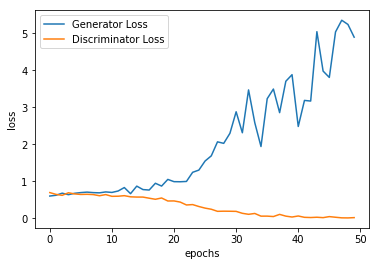

In [49]:
f,ax = plt.subplots(1,1)
ax.plot(gen_loss_list, label="Generator Loss")
ax.plot(disc_loss_list, label="Discriminator Loss")
ax.legend()
ax.set_xlabel("epochs"); ax.set_ylabel("loss")
f.savefig("output/loss_car_final.png")

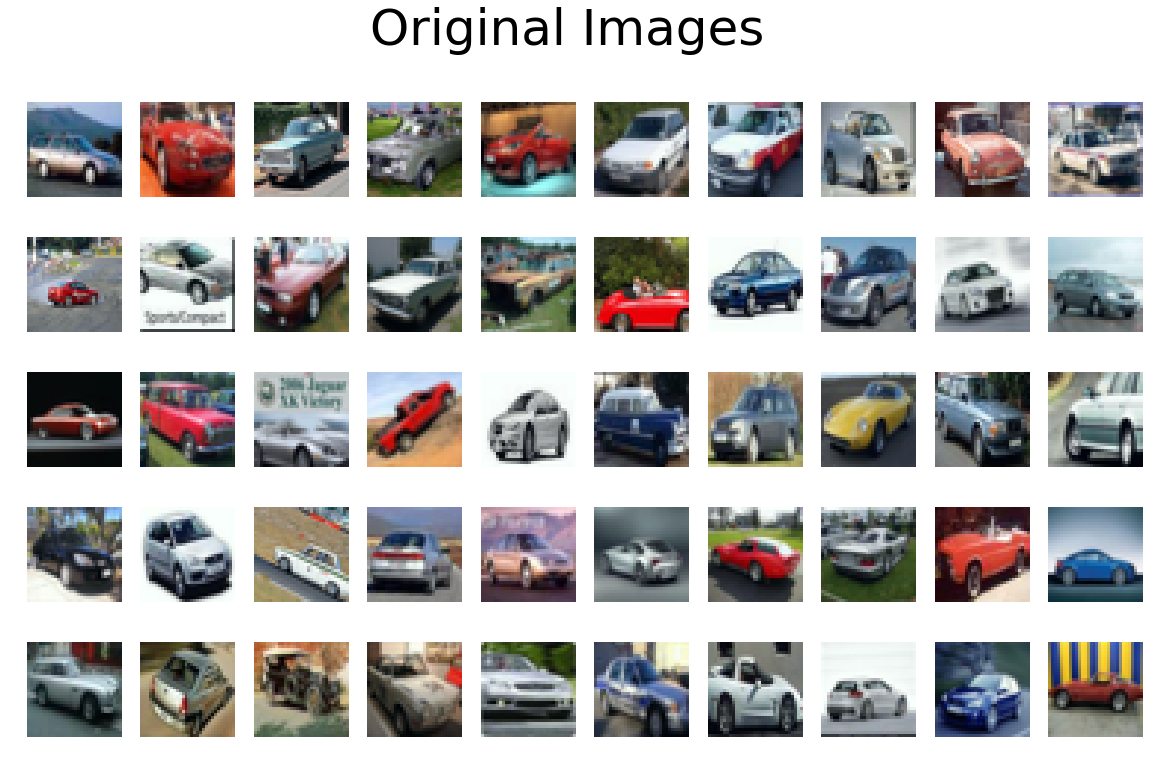

In [41]:
f,ax = plt.subplots(5,10, figsize=(20,12))
f.suptitle("Original Images", size=50)
ax=[axis for row in ax for axis in row]
for x,y in trainLoader:
    for i in range(len(ax)):
        xi=x[i].cpu().numpy()
        xi=np.moveaxis(xi,0,-1)
        xi-=xi.min(); xi/=xi.max()
        ax[i].imshow(xi)
        ax[i].axis("off")
    break

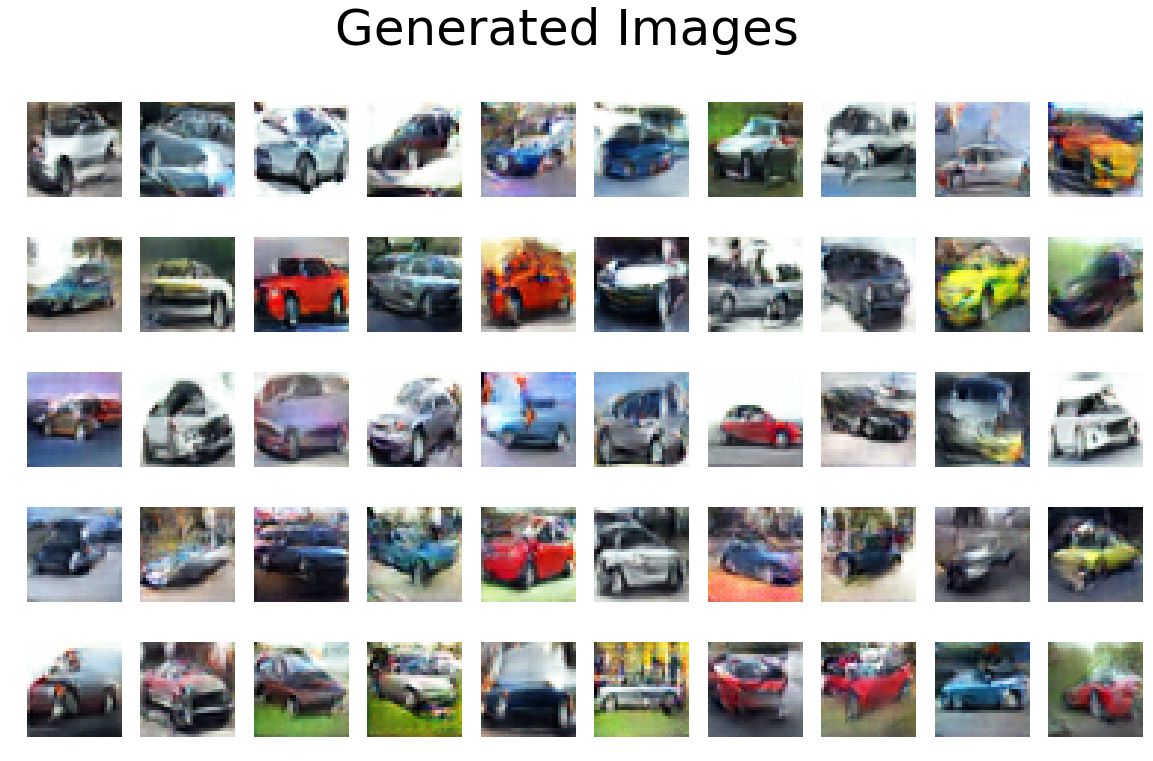

In [42]:
f2,ax2 = plt.subplots(5,10, figsize=(20,12))
f2.suptitle("Generated Images", size=50)
ax2=[axis for row in ax2 for axis in row]
z=torch.randn(len(ax2),100,1,1, device=device)
x=model_gen(z)
for i,axis in enumerate(ax2):
    xi=x[i].detach().cpu().numpy()
    xi=np.moveaxis(xi,0,-1)
    xi-=xi.min(); xi/=xi.max()
    axis.imshow(xi)
    axis.axis("off")

In [12]:
for x,_ in trainLoader:
    save_image(x[:50], filename="output/CAR_OG.png", nrow=10, normalize=True)
    break

In [13]:
save_image(model_gen(torch.randn(50,100,1,1, device=device)).data, filename="output/CAR_OUT.png" , nrow=10, normalize=True)